# Import Libraries

In [2]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm as tqdm_notebook
import json

# import onnx 
# import onnxruntime as ort


# Upload Dataset

In [3]:
cols = ["Holiday","Date","Generation","Consumption"]
df = pd.read_csv("/content/Generation_dataset_combined.csv", header=0, names=cols)
file = "/content/Generation_dataset_combined.csv"

In [4]:
print(df.head())

   Holiday                       Date  Generation  Consumption
0        0  2018-07-01 05:00:00+00:00      182340       509702
1        0  2018-07-01 06:00:00+00:00      285585       412574
2        0  2018-07-01 07:00:00+00:00      281322       390539
3        0  2018-07-01 08:00:00+00:00      324231       366425
4        0  2018-07-01 09:00:00+00:00      314379       354843


In [5]:
print(df.shape) #Check the shape of the dataset

(27019, 4)


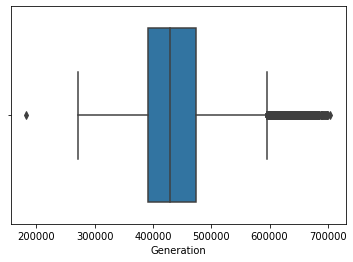

In [6]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df['Generation'])
plt.show()

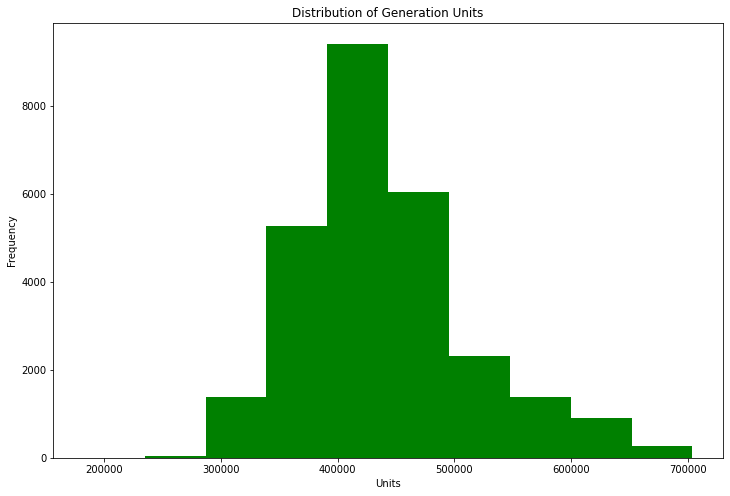

In [7]:
# Plot a histogram of the Generation column

fig = plt.figure(figsize=(12, 8))
plt.hist(df["Generation"], color='green')
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.title("Distribution of Generation Units")
plt.show()

In [8]:
# create a new column 'date' and fill it with the dates from 'datetime' column
df['time'] = pd.to_datetime(df['Date']).dt.time
df['hour'] = [t.hour for t in df['time']]
df['business hour'] = 0  # Initialize new column with 0s
for i in range(len(df)):
    hour = df.loc[i, 'hour']
    if ((hour >= 8 and hour < 14) or (hour >= 16 and hour < 21)):
        df.loc[i, 'business hour'] = 1  # Set value to 1 for business hours
df = df.drop(['hour','time'], axis=1)        

In [9]:
# create new columns for year, month, day, and hour

df['Date'] = pd.to_datetime(df['Date'], utc=True, infer_datetime_format=True)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour
df = df.drop('Date', axis=1)

In [10]:
df.dtypes

Holiday          int64
Generation       int64
Consumption      int64
business hour    int64
year             int64
month            int64
day              int64
hour             int64
dtype: object

In [11]:
df.head()

,Holiday,Generation,Consumption,business hour,year,month,day,hour
0,0,182340,509702,0,2018,7,1,5
1,0,285585,412574,0,2018,7,1,6
2,0,281322,390539,0,2018,7,1,7
3,0,324231,366425,1,2018,7,1,8
4,0,314379,354843,1,2018,7,1,9


In [12]:
# Find the correlations between the electricity price and the rest of the features

correlations = df.corr(method='pearson')
print(correlations['Generation'].sort_values(ascending=False).to_string())

Generation       1.000000
Consumption      0.906539
hour             0.193926
year             0.085825
month            0.040776
day              0.001501
Holiday         -0.034477
business hour   -0.185346


In [13]:
print(df.describe())

            Holiday     Generation    Consumption  business hour  \
count  27019.000000   27019.000000   27019.000000   27019.000000   
mean       0.051519  439651.924683  455204.401051       0.458418   
std        0.221059   72889.239516   75979.258484       0.498277   
min        0.000000  182340.000000  304812.000000       0.000000   
25%        0.000000  391401.500000  403703.000000       0.000000   
50%        0.000000  429362.000000  441196.000000       0.000000   
75%        0.000000  473154.500000  490910.000000       1.000000   
max        1.000000  704183.000000  710116.000000       1.000000   

               year         month           day          hour  
count  27019.000000  27019.000000  27019.000000  27019.000000  
mean    2019.536696      6.534550     15.729191     11.501758  
std        0.974703      3.403973      8.796289      6.921722  
min     2018.000000      1.000000      1.000000      0.000000  
25%     2019.000000      4.000000      8.000000      6.000000  
50%

In [14]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in combined_data.'
      .format(df.isnull().values.sum()))

temp_energy = df.duplicated(keep='first').sum()

print('There are {} duplicate rows in combined_data based on all columns.'
      .format(temp_energy))

There are 0 missing values or NaNs in combined_data.
There are 0 duplicate rows in combined_data based on all columns.


In [15]:
# Find the number of NaNs in each column

df.isnull().sum(axis=0)

Holiday          0
Generation       0
Consumption      0
business hour    0
year             0
month            0
day              0
hour             0
dtype: int64

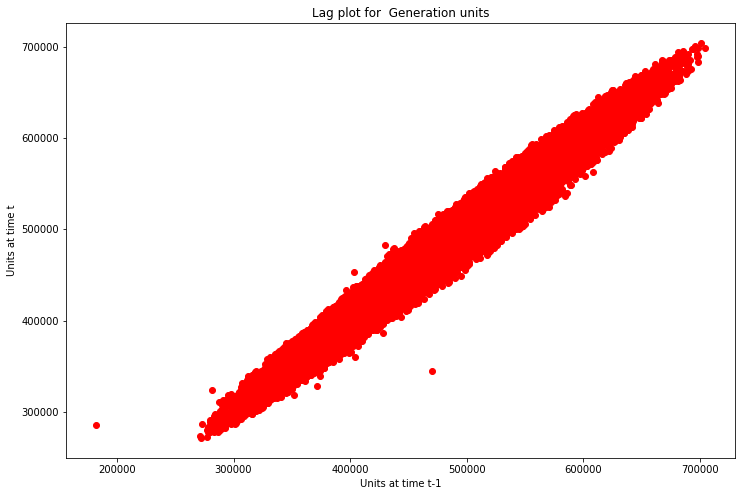

In [16]:
# Lag plot for Generation units
Total = df['Generation']
fig = plt.figure(figsize=(12, 8))
pd.plotting.lag_plot(Total, lag=1, c = 'red')
plt.title('Lag plot for  Generation units')
plt.xlabel('Units at time t-1')
plt.ylabel('Units at time t')
plt.show()

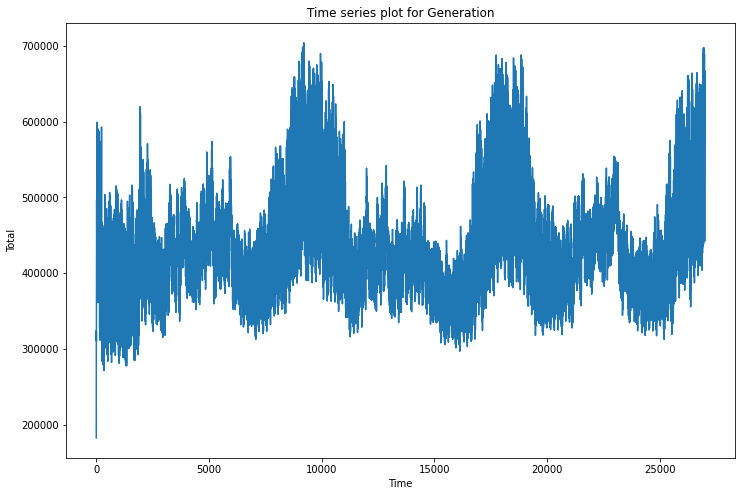

In [17]:
# Time series plot
Total = df['Generation']
fig = plt.figure(figsize=(12, 8))
plt.plot(Total)
plt.title('Time series plot for Generation')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()

In [18]:
# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

In [ ]:
df.head()

,Holiday,Generation,Consumption,business hour,year,month,day,hour
0,0,182340,509702,0,2018,7,1,5
1,0,285585,412574,0,2018,7,1,6
2,0,281322,390539,0,2018,7,1,7
3,0,324231,366425,1,2018,7,1,8
4,0,314379,354843,1,2018,7,1,9


In [19]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
 
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [20]:
label_col_index = 1 # Generation as label to predict
inputs_cols_indices =2,3,6,7  # use ["Holiday","Date","Consumption"] columns as features

window_size = 24

label_scalers = {}

train_x = []
test_x = {}
test_y = {}

In [21]:
label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
label_scalers[file] = label_sc

In [22]:
inputs, labels = move_sliding_window(data,window_size,inputs_cols_indices=inputs_cols_indices,label_col_index=label_col_index, )

test_portion = int(0.1 * len(inputs))
if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
test_x[file] = inputs[-test_portion:]
test_y[file] = labels[-test_portion:]

(26995, 24, 4) (26995, 1)


In [23]:
batch_size =16
# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42)

# Create TensorDatasets and DataLoaders for training and validation sets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [24]:
print(f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}")
print(f"Validation Size: {val_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(val_x.shape[0]/batch_size)}")

Train Size: (19436, 24, 4), Batch Size: 16, # of iterations per epoch: 1214
Validation Size: (4860, 24, 4), Batch Size: 16, # of iterations per epoch: 303


In [25]:
# release some memory
del train_x, train_y

In [26]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


# LSTM Model

In [27]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [72]:
def train(train_loader, val_loader, learn_rate, hidden_dim=256, n_layers=2, n_epochs=3, model_type="GRU", print_every=100, threshold=0.02):
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1

    # Instantiate the model
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()

        # Training loop
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        correct_count = 0
        total_count = 0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            diff = torch.abs(out - label.to(device).float())
            correct_count += (diff <= threshold).sum().item()
            total_count += diff.numel()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )

        current_time = time.process_time()
        train_losses.append(avg_loss / len(train_loader))
        train_acc = correct_count / total_count
        train_accs.append(train_acc)
        print(f"Epoch {epoch}/{n_epochs} Done, Train Loss: {train_losses[-1]}, Train Accuracy: {train_acc}")
        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct_count = 0
            total_count = 0
            for x, label in val_loader:
                h = model.init_hidden(batch_size)
                if model_type == "GRU":
                    h = h.data
                elif model_type == "LSTM":
                    h = tuple([e.data for e in h])

                out, h = model(x.to(device).float(), h)
                loss = criterion(out, label.to(device).float())
                val_loss += loss.item()

                diff = torch.abs(out - label.to(device).float())
                correct_count += (diff <= threshold).sum().item()
                total_count += diff.numel()

            val_losses.append(val_loss / len(val_loader))
            val_acc = correct_count / total_count
            val_accs.append(val_acc)
            print(f"Validation Loss: {val_losses[-1]} - Validation Accuracy: {val_acc}")
        model.train()
    
    # Plot the training and validation accuracy
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 2, 1)
    plt.plot(train_accs, label="Train accuracy")
    plt.plot(val_accs, label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Plot the training and validation losses
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    print(f"Total Training Time: {sum(epoch_times)} seconds")

    return model

# Training LSTM Model

Starting Training of LSTM model
Epoch 1 - Step: 1200/1214 - Average Loss for Epoch: 0.006772407049284084
Epoch 1/120 Done, Train Loss: 0.006750349251273789, Train Accuracy: 0.3103892092257002
Time Elapsed for Epoch: 5.3113054929999635 seconds
Validation Loss: 0.004391312197491637 - Validation Accuracy: 0.349009900990099
Epoch 2 - Step: 1200/1214 - Average Loss for Epoch: 0.004295950808203391
Epoch 2/120 Done, Train Loss: 0.004296744609344827, Train Accuracy: 0.3790671334431631
Time Elapsed for Epoch: 5.650080897000407 seconds
Validation Loss: 0.005589031325822247 - Validation Accuracy: 0.22112211221122113
Epoch 3 - Step: 1200/1214 - Average Loss for Epoch: 0.004069884871617736
Epoch 3/120 Done, Train Loss: 0.0040750311605791106, Train Accuracy: 0.4113467874794069
Time Elapsed for Epoch: 5.260845129000245 seconds
Validation Loss: 0.003695082761233568 - Validation Accuracy: 0.4535891089108911
Epoch 4 - Step: 1200/1214 - Average Loss for Epoch: 0.003983011156136248
Epoch 4/120 Done, Train

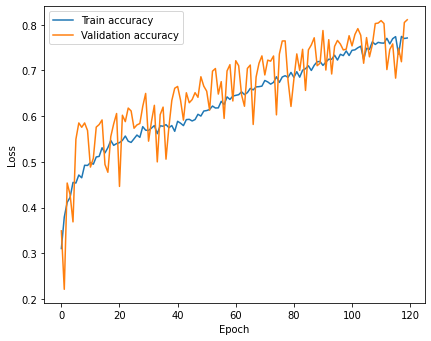

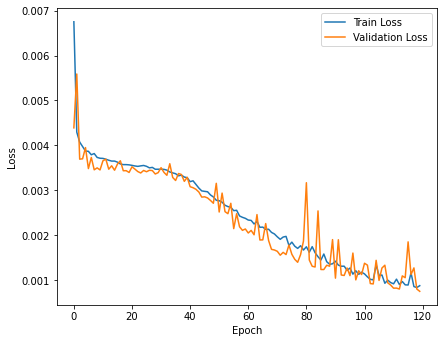

Total Training Time: 0 seconds


In [74]:
n_hidden = 256
n_layers = 2
n_epochs = 120
print_every = 1200
lr = 0.001
lstm_model = train(
    train_loader,
    val_loader=val_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

In [75]:
torch.save(lstm_model.state_dict(), "/content/model/lstm_model.pt")  # Save model to Model folder

In [89]:
torch.save(lstm_model.state_dict(), '/content/model/lstm_model.pt')
# Save the model architecture and other necessary information
model_info = {'input_dim': input_dim,'hidden_dim': hidden_dim,'output_dim': output_dim,'n_layers': n_layers,}
with open('generation_model_de.json', 'w') as f:
    json.dump(model_info, f)

In [ ]:
import torch
import h5py

# Save the model weights in Keras format
model_weights = lstm_model.state_dict()
with h5py.File('generation_model_weights_de.h5', 'w') as f:
    for key in model_weights:
        f.create_dataset(key, data=model_weights[key].numpy())


In [76]:
hidden_dim = 256
input_dim = 4
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/model/lstm_model.pt"))

<All keys matched successfully>

In [77]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(4, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

# Evaluation

In [78]:
def sMAPE(outputs, targets):
    sMAPE = (100/ len(targets) * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2))
    return sMAPE

In [79]:
def mean_absolute_error(targets, outputs):
    targets, outputs = np.array(targets), np.array(outputs)
    MAE = np.mean(np.abs(outputs - targets))
    return MAE

In [80]:
def mean_absolute_percentage_error(targets, outputs): 
    targets, outputs = np.array(targets), np.array(outputs)
    MAPE = np.mean(np.abs((targets - outputs) / targets)) * 100
    return MAPE

In [81]:
def rmse_percentage(targets, outputs):
    targets, outputs = np.array(targets), np.array(outputs)
    rmse = np.sqrt(np.mean((targets - outputs)**2))
    return (rmse/np.mean(targets)) * 100

In [82]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")
    print(f"MAPE: {round(mean_absolute_percentage_error(concatenated_outputs, concatenated_targets), 3)}%")
    print(f"MAE: {round(mean_absolute_error(concatenated_outputs, concatenated_targets), 2)}")
    print(f"RMSE: {round(rmse_percentage(concatenated_outputs, concatenated_targets), 2)}%")
    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

In [83]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 0.04961400999991383
sMAPE: 1.11%
MAPE: 4.848%
MAE: 20642.13
RMSE: 9.09%


In [84]:
len(lstm_outputs)  # list of predicted output file 

1

In [85]:
states_list = list(test_x.keys())

# Visualize results

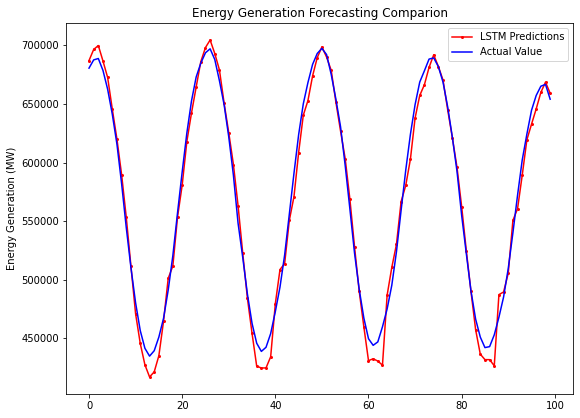

In [86]:
# Plot the actual vs predicted values
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[0][-100:], color="b", label="Actual Value")
plt.ylabel("Energy Generation (MW)")
plt.title(f"Energy Generation Forecasting Comparion")
plt.legend()